range(0, 7)
range(0, 14)
(array([[  5.25660722e-14,   5.32489218e-14,   4.85897585e-14,
          4.98003656e-14,   4.82606478e-14,   5.20740609e-14,
          5.15165171e-14,   4.93519052e-14,   5.22232461e-14,
          4.86687188e-14,   4.88639278e-14,   5.20872557e-14,
          4.69261274e-14,   4.87073585e-14,   5.31030403e-14,
          4.90619264e-14,   4.99456913e-14,   4.83838564e-14,
          4.86751613e-14,   4.93544269e-14,   4.89666177e-14,
          5.20452266e-14,   5.30540396e-14,   4.86871047e-14,
          1.75500785e-02,   1.55271392e-02,   1.53449895e-02,
          1.79103937e-02,   1.55296115e-02,   1.55851387e-02,
          1.54281014e-02,   1.47118299e-02,   1.51977538e-02,
          8.05412388e-02,   9.18101294e-02,   9.47823863e-02,
          1.45579781e-02,   1.74114888e-02,   5.11269154e-02,
          5.04209545e-02,   5.02058632e-02,   5.36580006e-02],
       [  3.10844029e-14,   3.14872945e-14,   2.87396437e-14,
          2.94614255e-14,   2.85549624e-14,

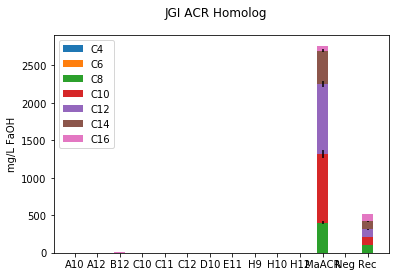

In [12]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import openpyxl
from statistics import * 

#User enters data here
file = 'GCData-JGI_ACRs w Conc Data.xlsx' #file name
sheet = 'Corrected Concentration' #sheet with corrected concentration data
samples = ['A10','A12','B12', 'C10','C11','C12','D10','E11','H9','H10','H12','MaACR','Neg','Rec'] #name of samples
numVials = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] #number of vials per sample in order of appearance
chains = ['C4','C6','C8','C10','C12','C14','C16'] #chain lenghts
title = 'JGI ACR Homolog' #graph title
ylabel = 'mg/L FaOH' #y axis label
#NOTE: Newer versions of python use 'sheet_name' instead of 'sheetname' when reading from excel. If you are getting a
#      read_excel() error, try changing 'sheetname' to 'sheet_name' in the second line of the getCorrectedConcentration
#      method.

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!') #love it
    
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    correctedConc = np.array(correctedConc)
    rearranged = np.zeros((numTotSamples, numChains))
    iterator = 0;
    for sample in range(0,numTotSamples):
        for chain in range(0, numChains):
            rearranged[sample, chain] = correctedConc[iterator]
            iterator = iterator + 1 
    return rearranged.T, rearranged.T.shape

#Calculates average and standard deviation of data
def calcStats(data):
    stats = [mean(data), stdev(data)]
    return stats

#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))
    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
            avgMat[r,c] = np.mean(rearranged[0][r][c*3:(c*3)+2]) # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
            stdevMat[r,c] = np.std(rearranged[0][r][c*3:(c*3)+2])
        
    return avgMat,stdevMat

#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, numVials, chains, title, ylabel):
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)
    #Data inconsistency? Check w/ Mike and delete later
    #concData[concData.index(339.52465146162808)]=0
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat, columns=samples)
    df_std = pd.DataFrame(stdevMat, columns=samples)

    #plot data
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    width = 0.5
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    fistplot = plt.bar(ind, firstMean, width, yerr=firstStd, label=chains[0])
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        plt.bar(ind, chainMean, width, bottom=sumMeans, yerr=chainStd, label=chains[chain])
    plt.xticks(ind,samples)
    plt.legend()
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.gcf().set_facecolor('white')
    plt.show
    
#returns clean list of corrected concentrations from an excel file
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheetname=sheet)
    correctedConc = []
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        if isinstance(conc, float) and not math.isnan(conc):
            correctedConc.append(conc)
    return correctedConc

createBarChart(file, sheet, samples, numVials, chains, title, ylabel)